# Homework 4

### Due: Sun Dec. 15 @ 11:59pm

In this homework we will covering NLP, Topic Modeling, Recommendation Engines and Timeseries Data

In Part 1 we will generate recommendations on products from a department store based on product descriptions.
We'll first transform the data into topics using Latent Dirichlet Approximation, and then generate recommendations based on this new representation.

In Part 2 we will perform some timeseries transformations on weather data to create a simple model for predicting temperature.

Instructions
Follow the comments below and fill in the blanks (____) to complete.

**Please 'Restart and Run All' prior to submission.**

**When submitting to Gradescope, please mark on which page each question is answered.**

Out of 59 points total.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline
np.random.seed(123)

# Part 1 : LDA and Recommendation Engine

We are going to create a recommendation engine for products from a department store.  
The recommendations will be based on the similarity of product descriptions.  
We'll query a product and get back a list of products that are similar.  
Instead of using the descriptions directly, we will first do some topic modeling using LDA to transform the descriptions into a topic space.

## Transform product descriptions into topics and print sample terms from topics


In [2]:
# 1. (2pts) Load the Data

# The dataset we'll be working with is a set of product descriptions from JCPenney.

# Load product information from ../data/jcpenney-products_subset.csv.zip
# This is compressed version of a csv file.
# Use pandas read_csv function with the default parameters.
# read_csv has a parameter compression with default value 'infer' that will handle unzipping the data.
# Store the resulting dataframe as df_products.
df_products = pd.read_csv('../data/jcpenney-products_subset.csv.zip')
# print a summary of df_products using .info, noting the number of records (should be 5000)
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
uniq_id          5000 non-null object
sku              5000 non-null object
name_title       5000 non-null object
description      5000 non-null object
category         4698 non-null object
category_tree    4698 non-null object
dtypes: object(6)
memory usage: 234.5+ KB


In [3]:
# 2. (2pts) Print an Example

# The two columns of the dataframe we're interested in are:
#   name_title which is the name of the product stored as a string
#   description which is a description of the product stored as a string
#
# We'll print out the product in the first row as an example
# If we try to print both at the same time, pandas will truncate the strings
#   so we'll print them seperately

# print the product name_title in row 0 of df_products
print(df_products.name_title[0])

# print the product desciption in row 0 of df_products
print(df_products.description[0])

Alfred Dunner® Essential Pull On Capri Pant
You'll return to our Alfred Dunner pull-on capris again and again when you want an updated, casual look and all the comfort you love.   elastic waistband approx. 19-21" inseam slash pockets polyester washable imported      


In [4]:
# 3. (4pts) Transform Descriptions using TfIdf

# In order to pass our product descriptions to the LDA model, we first need to vectorize from strings to 
#   fixed vectors of floats.
# To do this we will transform our documents into unigrams using Tf-Idf,
#    use both unigrams and bigrams
#    excluding terms which appear in less than 10 documents
#    excluding common English stop words and

# Import TfidfVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

#  Instantiate a TfidfVectorizer with
#   ngram_range=(1,2),
#   min_df=10,
#   stop_words='english'
# Store as tfidf
tfidf = TfidfVectorizer(ngram_range = (1,2), min_df = 10, stop_words = 'english')

# fit_transform tfidf on the descriptions column of our dataframe, creating the transformed dataset X_tfidf
# Store as X_tfidf
X_tfidf = tfidf.fit_transform(df_products.description)

# Print the shape of X_tfidf (should be 5000 x 3979)
print(X_tfidf.shape)

(5000, 3979)


In [5]:
# 4. (3pts) Format Bigram Labels and Print Sample of Extracted Vocabulary 

# The extracted vocabulary cat be retrieved from tfidf as a list using get_feature_names()
# Store the extracted vocabulary as vocabulary
vocabulary = tfidf.get_feature_names()

# Sklearn joins bigrams with a space character.
# To make output easier to read, replace all spaces in our vocabulary list with underscores.
# To do this we can use the string replace() method.
# For example x.replace(' ','_') with replace all ' ' in x with '_'.
# Store the result back in vocabulary.
vocabulary = [x.replace(' ','_') for x in vocabulary]

# Print the last 5 terms in the vocabulary
print(vocabulary[-5:])

['zipper_pockets', 'zippered', 'zippers', 'zirconia', 'zone']


In [6]:
# 5. (4pts) Perform Topic Modeling with LDA

# Now that we have our vectorized data, we can use Latent Direchlet Allocation to learn 
#   per-document topic distributions and per-topic term distributions.
# Though there are likely more, we'll model our dataset using 20 topics to keep things small.
# We'd like the model to run on all of the cores available in the machine we're using.
#    `n_jobs` tells the model how many cores to use, while `n_jobs=-1` indicates use all available.
# We'd also like the results to always be the same, so set random_state=123

# Import LatentDirichletAllocation from sklearn.decomposition
from sklearn.decomposition import LatentDirichletAllocation

# Instantiate a LatentDirichletAllocation model with
#    n_components=20, n_jobs=-1, random_state=123
# Store as lda
lda = LatentDirichletAllocation(n_components=20, n_jobs = -1, random_state = 123)

# Run fit_transform on lda using X_tfidf.
# Store the output (the per-document topic distributions) as X_lda
# NOTE: this step may take a minute or more depending on your setup.
X_lda = lda.fit_transform(X_tfidf)

# Print the shape of the X_lda (should be 5000 x 20)
print(X_lda.shape)

(5000, 20)


In [7]:
# 6. (4pts) Print Top Topic Terms

# To get a sense of what each topic is composed of, we can print the most likely terms for each topic.
# We'd like a print statement that looks like this:
#    Topic #0 upper sole rubber synthetic rubber_sole
#
# For each topic print 'Topic #{idx} ' followed by the top 5 most likely terms in that topic.
# Hints: 
#   Use vocabulary created above, but first convert from a list to np.array to make indexing easier
#   The per topic term distributions are stored in model.components_
#   np.argsort returns the indices of an np.array sorted by their value, in ascending order
#   [::-1] reverses the order of an np.array

for topic_idx, topic in enumerate(lda.components_):
    result = "Topic #{:#2d}: ".format(topic_idx)
    result += " ".join([vocabulary[i] for i in topic.argsort()[:-6:-1]])
    print(result)



Topic # 0: upper sole rubber synthetic rubber_sole
Topic # 1: pockets zip pocket interior closure
Topic # 2: dry wash length polyester spandex
Topic # 3: cotton washable_imported washable sleeves short
Topic # 4: swim spandex_hand hand_wash lined partially_lined
Topic # 5: sheet ci pillowcases fitted_sheet snaps
Topic # 6: dress spandex_polyester return condition condition_green
Topic # 7: clean measures imported design spot
Topic # 8: safe dishwasher dishwasher_safe stainless_steel stainless
Topic # 9: sleeves washable_imported washable polyester_washable cotton
Topic #10: jewelry photos enlarged photos_enlarged metal
Topic #11: door shelves bedskirt energy hidden
Topic #12: wicking moisture moisture_wicking dri wicking_fabric
Topic #13: star star_wars wars swimsuit dye
Topic #14: pockets button closure rod button_closure
Topic #15: sleepwear safety widemodel children breathability
Topic #16: basket silky soap cook foundry_supply
Topic #17: rug resistant yes indoor rug_pad
Topic #18: 

### Generate recommendations using topics

In [8]:
# 7. (3pts) Generate Similarity Matrix

# We'll use Content Filtering to make recommendations based on a query product.
# Each product will be represented by its LDA topic weights learned above.
# We'd like to recommend similar products in LDA space.
# We'll use cosine_similarity as measure of similarity.

# From sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

# Use cosine_similarity to generate similarity scores on our X_lda data
# Store as similarities.
# NOTE: we only need to pass X_lda in once,
#   the function will calculate pairwise similarity for all elements in that matrix
similarities = cosine_similarity(X_lda)

# print the shape of the similarities matrix (should be 5000x5000)
print(similarities.shape)

(5000, 5000)


In [9]:
# 8.(4pts) Generate Recommendations

# Let's test our proposed recommendation engine using the product at row 0 in df_products.
#   The name of this product is "Alfred Dunner® Essential Pull On Capri Pant"

# Print the names for the top 10 most similar products to this query.
# Suggested way to do this is:
#   get the cosine similarities from row 0 of the similarities matrix
#   get the indices of this array sorted by value using np.argsort
#   reverse the order of these indices (remember, we want high values and np.argsort evaluates ascending)
#   get the first 10 indexes from this reversed array
#   use those indices to index into df_products.name_title and print the result

# HINT: The first two products should be:
#   'Alfred Dunner® Essential Pull On Capri Pant', (the original query product)
#   'Alfred Dunner® Pull-On Pants - Plus',

top10_id = np.argsort(similarities[0])[::-1][0:10]
for idx in top10_id:
    print(df_products.name_title[idx])
    

Alfred Dunner® Essential Pull On Capri Pant
Lee® Austyn Cargo Capris
Levi's® 505™ Regular Jeans - Boys 8-20, Slim and Husky
Made for Life™ Pintucked Bermuda Shorts
Alfred Dunner® Pull On Pant
Vanilla Star® Denim Bermuda Shorts with Embellished Pockets - Girls 7-16 and Plus
Alfred Dunner® Santa Clara Pull-On Pants - Plus
Love Indigo Embellished Back Pocket Jeans
Arizona Knit Jeggings - Girls 7-16 and Plus
Switch® Polyester Soccer Pants


# Part 2 : Timeseries Data

We are going to create a very simple model to predict average daily temperature at Laguardia Airport 2 days in the future. This point here isn't to generate a great model, but instead to get some practice with timeseries transformations and model evaluation.

This data was collected from https://rp5.ru/Weather_archive_in_New_York,_La_Guardia_(airport)

Before we do any modeling we need to resample and visualize the data.

In [10]:
# 9. (3pts) Load Weather Data

# Read in the our historical Laguardia weather data from '../data/weather_lga.csv.zip'.
# The data includes a column 'timestamp' that we'll use as our index.
# Use read_csv with default parameters except:
#   set index_col to 'timestamp'
#   pass 'timestamp' as the only element of a list to parse_dates 
# Store the result as df_weather
df_weather = pd.read_csv('../data/weather_lga.csv.zip', index_col='timestamp', parse_dates=['timestamp'])

# Print the info of df_weather
#   Should be 14600 rows by 10 columns with no missing values)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14600 entries, 2014-11-28 01:00:00 to 2019-11-28 22:00:00
Data columns (total 10 columns):
temperature                   14600 non-null float64
pressure                      14600 non-null float64
pressure_sealevel             14600 non-null float64
pressure_changeslast3hours    14600 non-null float64
relativehumidity              14600 non-null float64
windspeed                     14600 non-null float64
maxwindgust_prior10minutes    14600 non-null float64
horizontalvisibility          14600 non-null float64
temperature_dewpoint          14600 non-null float64
precipitation_amount          14600 non-null float64
dtypes: float64(10)
memory usage: 1.2 MB


In [11]:
# 10. (1pt) Examine Index

# Print out the first 5 elements of the index of df_weather.
# Note that there is more than one observation per day
df_weather[:5]

,temperature,pressure,pressure_sealevel,pressure_changeslast3hours,relativehumidity,windspeed,maxwindgust_prior10minutes,horizontalvisibility,temperature_dewpoint,precipitation_amount
timestamp,,,,,,,,,,
2014-11-28 01:00:00,1.1,762.5,763.5,0.3,70.0,5.0,0.0,16.0,-3.9,0.0
2014-11-28 04:00:00,0.0,763.0,764.0,0.5,69.0,6.0,0.0,16.0,-5.0,0.0
2014-11-28 07:00:00,0.0,764.2,765.2,1.2,73.0,8.0,11.0,16.0,-4.4,0.0
2014-11-28 10:00:00,1.1,765.5,766.4,1.3,59.0,9.0,12.0,16.0,-6.1,0.0
2014-11-28 13:00:00,2.2,764.8,765.8,-0.7,55.0,7.0,11.0,16.0,-6.1,0.0


In [12]:
# 11. (3pts) Downsample and Aggregate

# We'll downsample our data to a daily frequency.
# Since we're downsampling, we need to aggregate observations.
# For this exercise, we'll aggregate using mean.
# Store the result of the downsample and aggregation as df_daily
df_daily = df_weather.resample('D').mean()

# Print the info of df_daily.
#    Should be 1827 rows by 10 columns with an index with daily frequency
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2014-11-28 to 2019-11-28
Freq: D
Data columns (total 10 columns):
temperature                   1827 non-null float64
pressure                      1827 non-null float64
pressure_sealevel             1827 non-null float64
pressure_changeslast3hours    1827 non-null float64
relativehumidity              1827 non-null float64
windspeed                     1827 non-null float64
maxwindgust_prior10minutes    1827 non-null float64
horizontalvisibility          1827 non-null float64
temperature_dewpoint          1827 non-null float64
precipitation_amount          1827 non-null float64
dtypes: float64(10)
memory usage: 157.0 KB


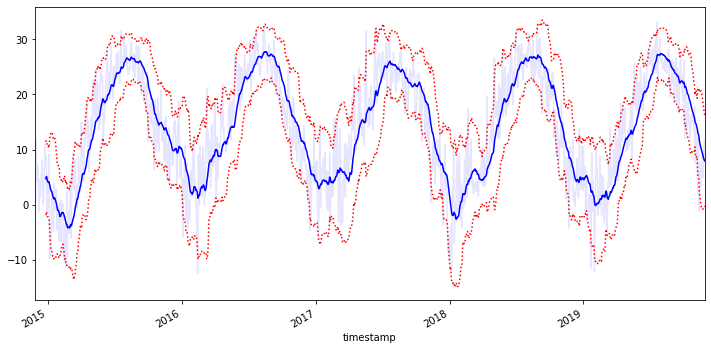

In [13]:
# 12. (6pts) Visualize Temperature

# We'd like to plot temperature over time as well as a smoothed version with standard deviation

# First, create a fig,ax using subplots with figsize=(12,6)
fig,ax = plt.subplots(figsize=(12,6))
# On ax, plot the temperature column of df_daily, use a solid blue line with alpha value 0.1
ax.plot(df_daily.temperature,color = 'b', alpha = 0.1);

# Create a rolling object for a 30 window on temperature
#   All parameters of rolling default except for the window size
# Store as rolling_temp
rolling_temp = df_daily.temperature.rolling(30);

# On ax, plot the mean of rolling_temp, use a solid blue line
rolling_temp.mean().plot(c='b');

# On ax, plot the mean of rolling_temp plus 2 standard deviations, use a dotted red line
(rolling_temp.mean()+2*rolling_temp.std()).plot(style=':',c= 'r');

# On ax, plot the mean of rolling_temp minus 2 standard deviations, use a dotted red line
(rolling_temp.mean()-2*rolling_temp.std()).plot(style=':',c= 'r');

## Create Model to Predict Temperature

Now we'll create a very simple model to predit temperature 2 days in the future. This is the same as saying we'd like to predict today's temperature using data 2 days in the past.

We'll create two models
 1. using only the temperature from 2 days in the past
 2. using the full set of features from 2 days in the past joined with all features from 1 year in the past

In [14]:
# For use in this section
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

In [15]:
# 13. (2pts) Create Dataset of 2 days ago

# We need to align the temperature on the current date with data from 2 days prior.
# To do this we'll shift all data 2 days forward

# Shift all data in df_daily two days forward
# Store in df_twodaysprior
df_twodaysprior = df_daily.shift(2)

# Check that the data in df_twodaysprior is in fact the data in df_daily shifted two days (provided)
assert np.all(df_twodaysprior.loc['2019-11-28'].values == df_daily.loc['2019-11-26'].values)

# Print the shape of df_twodaysprior (should be the same as df_daily, 1827 x 10)
print(df_twodaysprior.shape)

(1827, 10)


In [16]:
# 14. (4pts) Create Dataset of 1 Year Ago

# We'd also like to use data from 1 year ago.
# To do this we'll shift all data 365 days forward

# # Shift all data in df_daily two days forward
# Store in df_oneyearprior
df_oneyearprior = df_daily.shift(365)

# Check that the data in df_oneyearprior is in fact the data in df_daily shifted 365 days
#   Use a similar assert statement to the one in Question 13
#   Compare date range '2019-11-27' to '2019-11-28' in df_oneyearprior 
#      to the same dates one year prior in df_daily
assert np.all(df_oneyearprior.loc['2019-11-27':'2019-11-28'].values == df_daily.loc['2018-11-27':'2018-11-28'].values)

# Print the shape of df_oneyearprior (should be the same as df_daily, 1827 x 10)
print(df_oneyearprior.shape)

(1827, 10)


In [17]:
# 15. (2pts) Modify df_oneyearprior Column Names

# In order to make model interpretation easier later, 
#   we'll modify the column names df_oneyearprior.

# Prepend all column names in df_oneyearprior with the string 'oneyearprior_'
df_oneyearprior = df_oneyearprior.add_prefix('oneyearprior_')
# Print out the first two column names in df_oneyearprior (first should be 'oneyearprior_temperature')
df_oneyearprior.columns[:2]

Index(['oneyearprior_temperature', 'oneyearprior_pressure'], dtype='object')

In [18]:
# 16. (4pts) Create Model Using df_twodaysprior

# Now we'll create and evaluate a Lasso model trained on df_twodaysprior to predict temperature in df_daily.
# In order to aviod any missing data due to shifting, we'll only be using data from 
#   '2015-11-28' to '2019-11-28'

# Extract our target temperature from df_daily rows 
#    corresponding to dates from  '2015-11-28' to '2019-11-28' inclusive
# Store in y
y = df_daily.temperature.loc['2015-11-28':'2019-11-28']

# Extract the temperature column from  df_twodaysprior as a dataframe
#    corresponding to dates from  '2015-11-28' to '2019-11-28' inclusive
# Recall that to extract a single column as a dataframe, we can pass a list with a single value
# Store in X1
X1= df_twodaysprior[['temperature']].loc['2015-11-28':'2019-11-28']

# Generate 5-fold R^2 cross validation scores using Lasso with default values, X1 and y
# Store in scores
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
lasso = Lasso()

scores = cross_val_score(lasso, X1, y, cv=5)

# Print the mean of scores. (Note that this score may seem surprisingly high.)
print(scores.mean())

0.7504069358404043


In [19]:
# 17. (4pts) Create Model Using df_twodaysprior and df_oneyearprior

# Now we'll create and evaluate a Lasso model trained on both df_twodaysprior and df_oneyearlater.
# As before we'll only be using data from '2015-11-28' to '2019-11-28' inclusive
# We'll use the same y as in the questions above.

# Join the rows corresponding to the dates in our target y from df_twodaysprior with those from df_oneyearprior
# Since the indices should be the same, we can use the join function.
# Store the result in X2
X2 = df_twodaysprior.loc['2015-11-28':'2019-11-28'].join(df_oneyearprior)

# Generate 5-fold R^2 cross validation scores using Lasso with default values, X2 and y
# Store in scores
lasso = Lasso()
scores = cross_val_score(lasso, X2, y, cv =5)

# Print the mean of scores. You should see a slight improvement
print(scores.mean())

0.7911960330948566


In [20]:
# 18. (4pts) Select Important Features From Second Model

# Instantiate SelectFromModel with a Lasso model, both with default values, and fit on X2 and y
# Store the result as sfm
from sklearn.feature_selection import SelectFromModel
lasso = Lasso()
sfm = SelectFromModel(lasso).fit(X2,y)

# Get the chosen features from sfm using get_support
features = sfm.get_support()

# Using the column names in X2 and support, print out each chosen featurename on a separate line
res = list(X2.columns[features])
for r in res:
    print(r)

temperature
pressure
relativehumidity
oneyearprior_temperature
oneyearprior_relativehumidity
